In [1]:
import os 
import numpy as np
import pandas as pd
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import scgen
import seaborn as sns
from scipy import stats
import matplotlib
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('xtick', labelsize=18)

/Users/Future/Library/Python/3.6/lib/python/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
path_to_save = "../results/Figures/Supplemental Figure 2/"
os.makedirs(path_to_save, exist_ok=True)
sc.settings.figdir = path_to_save

In [3]:
pbmc = sc.read("../data/train_pbmc.h5ad")
pbmc

AnnData object with n_obs × n_vars = 16893 × 6998 
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [4]:
scgen_recon = sc.read("../data/reconstructed/scGen/pbmc.h5ad")
ctrl = scgen_recon[scgen_recon.obs["condition"] == "CD4T_ctrl"]
real_stim = scgen_recon[scgen_recon.obs["condition"] == "CD4T_real_stim"]
scgen_recon = scgen_recon[scgen_recon.obs["condition"].isin(["CD4T_real_stim", "CD4T_pred_stim", "CD4T_ctrl"])]
scgen_recon

View of AnnData object with n_obs × n_vars = 8001 × 6998 
    obs: 'batch', 'cell_type', 'condition'

In [5]:
cvae = sc.read("../data/reconstructed/CVAE/CVAE_CD4T.h5ad")

In [6]:
stgan = sc.read("../data/reconstructed/CGAN/cgan_cd4t.h5ad")

In [7]:
vecArith = sc.read("../data/reconstructed/VecArithm/VecArithm_CD4T.h5ad")

In [8]:
pca = sc.read("../data/reconstructed/PCAVecArithm/PCA_CD4T.h5ad")

In [9]:
cd4t = pbmc[pbmc.obs["cell_type"] == "CD4T"]
sc.tl.rank_genes_groups(cd4t, groupby="condition", n_genes=100, method="wilcoxon")
diff_genes = cd4t.uns["rank_genes_groups"]["names"]["stimulated"]

### Suppl. Figure 2.a

In [10]:
def make_plots(adata, conditions, model_name, figure, x_coeff=0.3, y_coeff=0.1):
    if model_name == "RealCD4T":
        mean_labels = {"x": "ctrl mean", "y": "stim mean"}
        var_labels = {"x": "ctrl var", "y": "stim var"}
    else:
        mean_labels = {"x": "pred mean", "y": "stim mean"}
        var_labels = {"x": "pred var", "y": "stim var"}
    scgen.plotting.reg_mean_plot(adata, 
                                 condition_key="condition",
                                 axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                                 gene_list=diff_genes[:5],
                                 top_100_genes=diff_genes,
                                 path_to_save=os.path.join(path_to_save, f"SupplFig2{figure}_{model_name}_reg_mean.pdf"),
                                 legend=False,
                                 title="",
                                 labels=mean_labels,
                                 fontsize=26,
                                 textsize=18,
                                 x_coeff=x_coeff,
                                 y_coeff=y_coeff,
                                 show=True,
                                 range=[0, 5, 1])
    
    scgen.plotting.reg_var_plot(adata, 
                                condition_key="condition",
                                axis_keys={"x": conditions["pred_stim"], "y": conditions["real_stim"]},
                                gene_list=diff_genes[:5],
                                top_100_genes=diff_genes,
                                path_to_save=os.path.join(path_to_save, f"SupplFig2{figure}_{model_name}_reg_var.pdf"),
                                legend=False,
                                labels=var_labels,
                                title="",
                                fontsize=26,
                                textsize=18,
                                x_coeff=x_coeff,
                                y_coeff=y_coeff,
                                show=True)
    if model_name == "scGen":
        adata = adata[adata.obs["condition"].isin(["CD4T_ctrl", "CD4T_pred_stim", "CD4T_real_stim"])]
        adata.obs["condition"].replace("CD4T_ctrl", "ctrl", inplace=True)
        adata.obs["condition"].replace("CD4T_real_stim", "real_stim", inplace=True)
        adata.obs["condition"].replace("CD4T_pred_stim", "pred_stim", inplace=True)
    sc.pp.neighbors(adata, n_neighbors=20)
    sc.tl.umap(adata, min_dist=1.1)
    import matplotlib.style
    plt.style.use('default')
    if model_name == "scGen":
        sc.pl.umap(adata, color=["condition"],
                   legend_loc=False,
                   frameon=False,
                   title="",
                   palette=matplotlib.rcParams["axes.prop_cycle"],
                   save=f"_latent_conditions.png",
                   show=True)
    else:
        if model_name == "RealCD4T":
            sc.pl.umap(adata, color=["condition"],
                   legend_loc=False,
                   frameon=False,
                   title="",
                   palette=['#1f77b4', '#2ca02c'],
                   save=f"_latent_conditions.png",
                   show=True)
        else:
            
            sc.pl.umap(adata, color=["condition"],
                       legend_loc=False,
                       frameon=False,
                       title="",
                       palette=matplotlib.rcParams["axes.prop_cycle"],
                       save=f"_latent_conditions.png",
                       show=True)
    
    os.rename(src=os.path.join(path_to_save, "umap_latent_conditions.png"), 
              dst=os.path.join(path_to_save, f"SupplFig2{figure}_{model_name}_umap.png"))

0.9725512453489008
0.9713736215099469


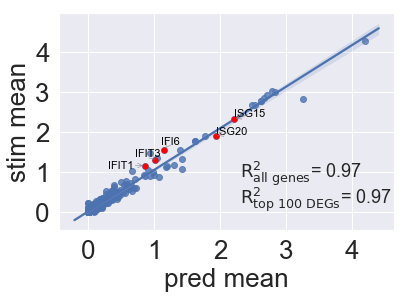

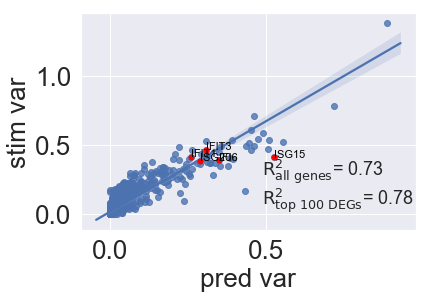

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'condition' as categorical


saving figure to file ../results/Figures/Supplemental Figure 2/umap_latent_conditions.png


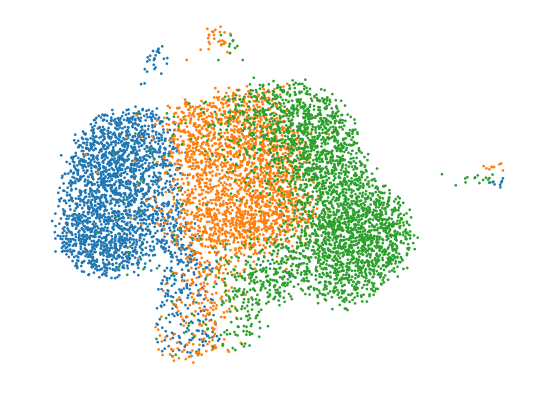

In [11]:
conditions = {"real_stim": "CD4T_real_stim", "pred_stim": "CD4T_pred_stim"}
make_plots(scgen_recon, conditions, "scGen", "a", 0.45, 0.8)

0.9528060589444522
0.9131664824256247


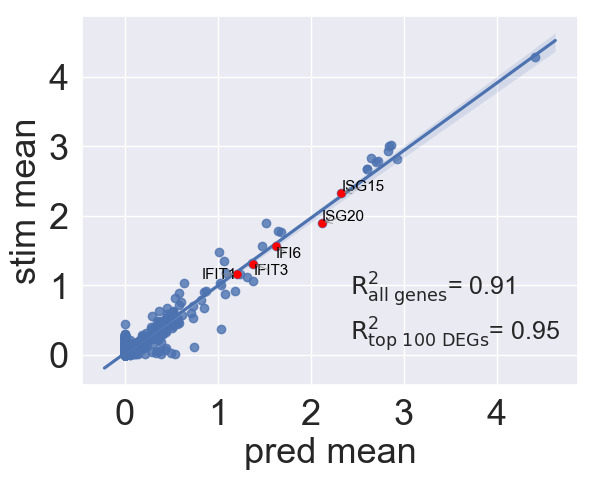

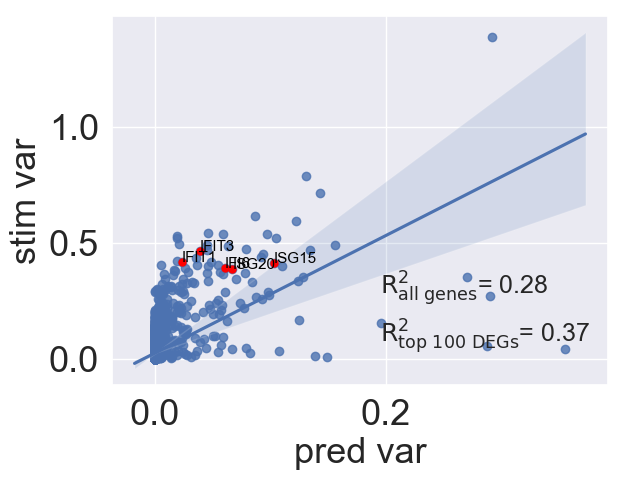

         Falling back to preprocessing with `sc.pp.pca` and default params.
saving figure to file ../results/Figures/Supplemental Figure 2/umap_latent_conditions.png


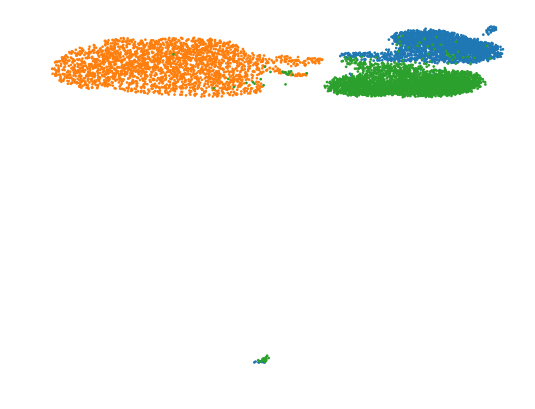

In [12]:
conditions = {"real_stim": "CD4T_real_stim", "pred_stim": "CD4T_pred_stim"}
make_plots(cvae, conditions, "CVAE", "b", 0.45, 0.8)

0.07746579582198972
0.13097755551180743


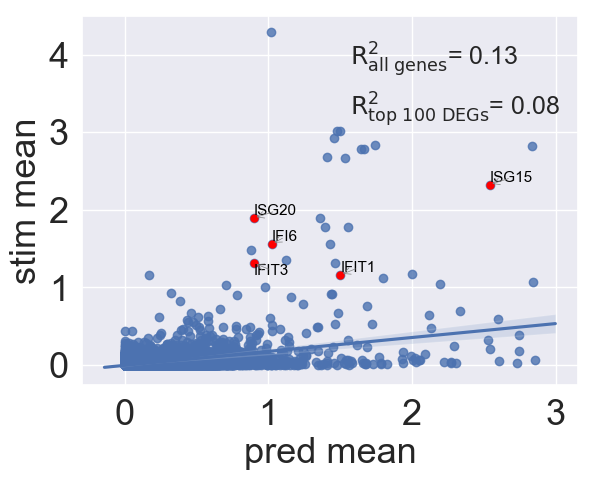

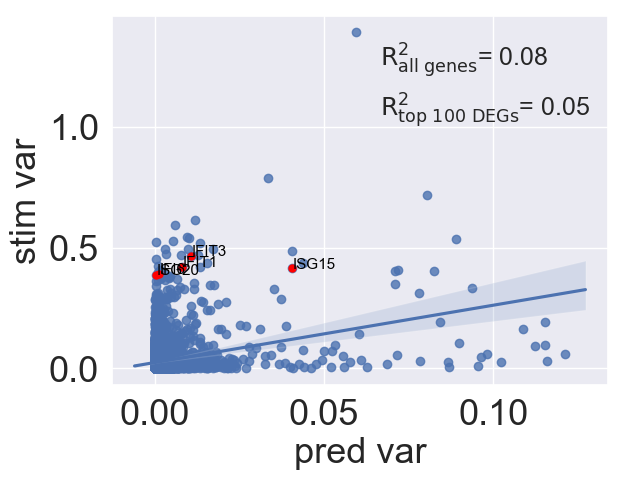

         Falling back to preprocessing with `sc.pp.pca` and default params.
saving figure to file ../results/Figures/Supplemental Figure 2/umap_latent_conditions.png


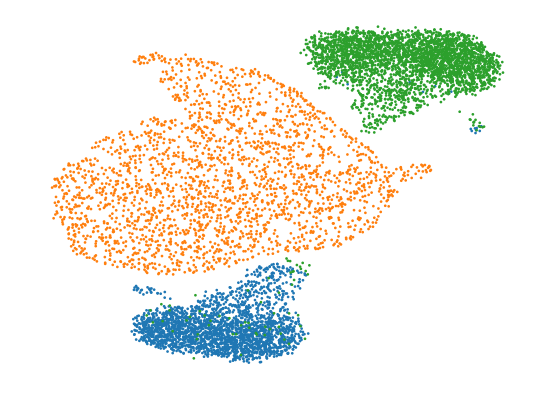

In [13]:
conditions = {"real_stim": "real_stim", "pred_stim": "pred_stim"}
make_plots(stgan, conditions, "Style Transfer GAN", "c", 0.45)

0.8085198949634397
0.8950722611226113


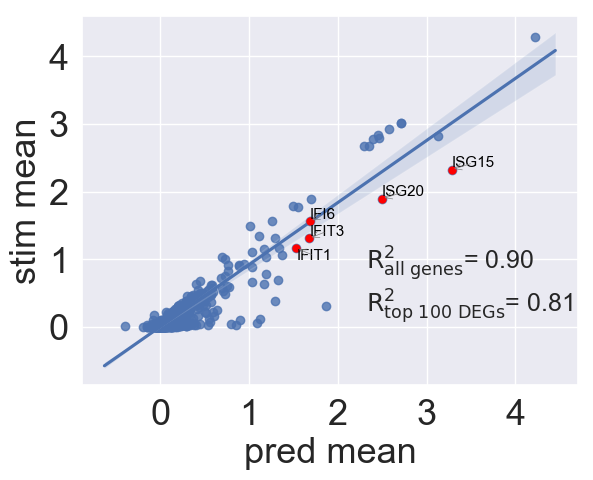

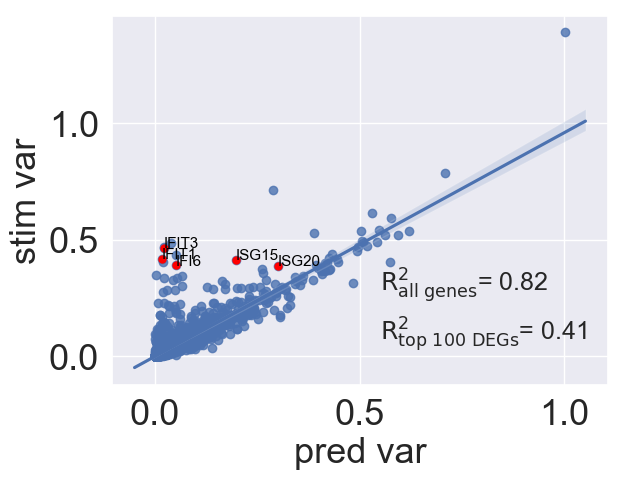

         Falling back to preprocessing with `sc.pp.pca` and default params.
saving figure to file ../results/Figures/Supplemental Figure 2/umap_latent_conditions.png


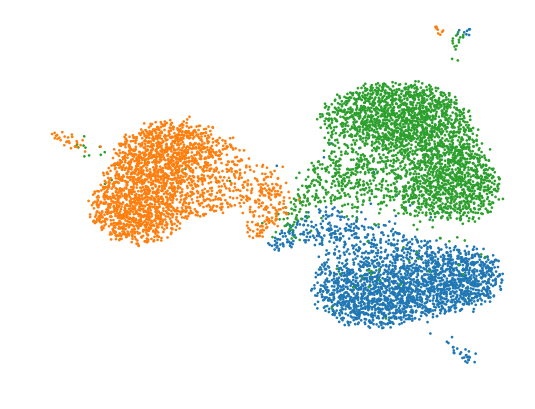

In [14]:
conditions = {"real_stim": "real_stim", "pred_stim": "pred_stim"}
make_plots(vecArith, conditions, "Vec. Arith.", "d", 0.45, 0.8)

0.810540741835654
0.8968271875331962


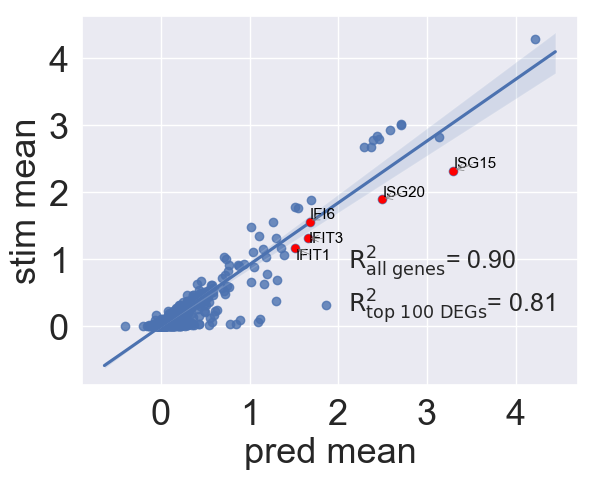

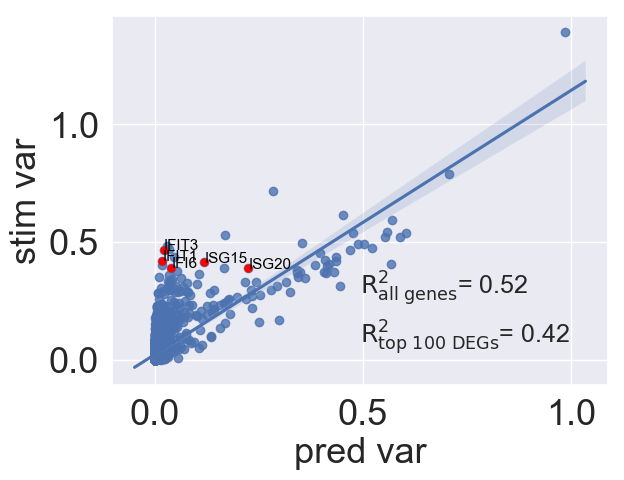

         Falling back to preprocessing with `sc.pp.pca` and default params.
saving figure to file ../results/Figures/Supplemental Figure 2/umap_latent_conditions.png


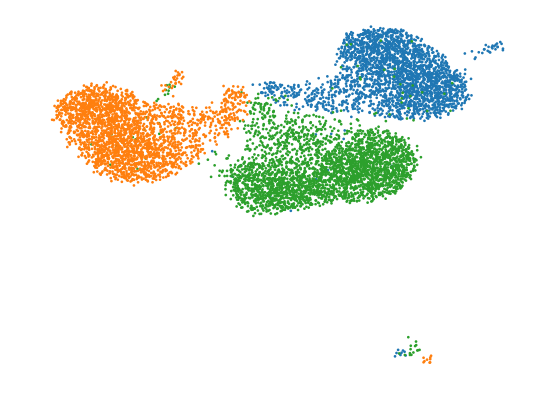

In [15]:
conditions = {"real_stim": "real_stim", "pred_stim": "pred_stim"}
make_plots(pca, conditions, "PCA + Vec. Arith.", "e", 0.5, 0.8)

0.6522499377540695
0.8672060003848516


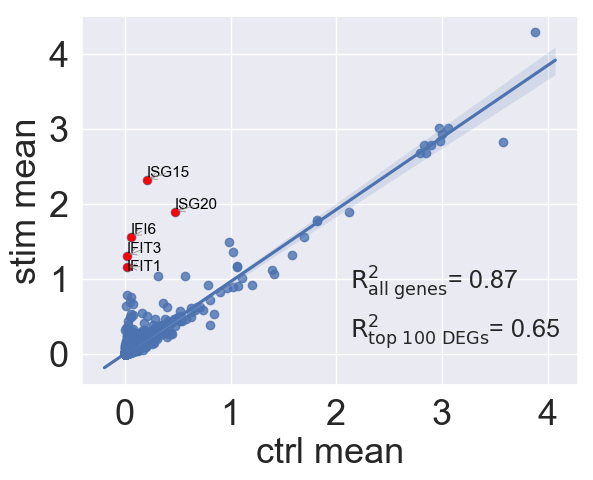

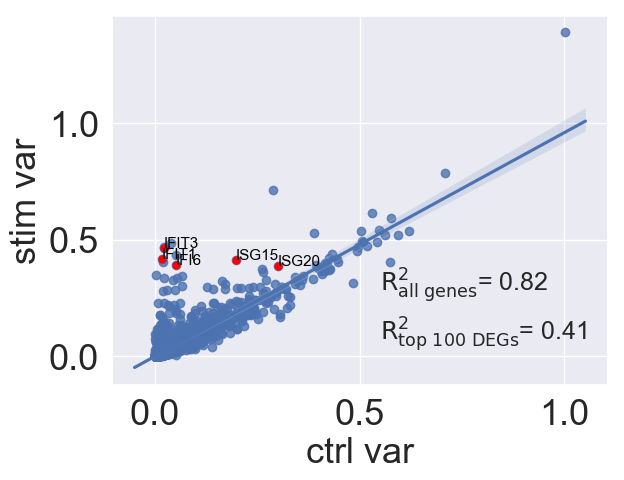

saving figure to file ../results/Figures/Supplemental Figure 2/umap_latent_conditions.png


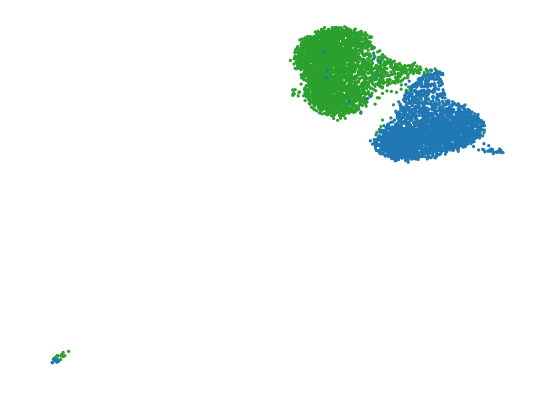

In [16]:
conditions = {"real_stim": "stimulated", "pred_stim": "control"}
pbmc_cd4t = pbmc[pbmc.obs["cell_type"] == "CD4T"]
make_plots(pbmc_cd4t, conditions, "RealCD4T", "f", 0.45, 0.8) 